# Introduction

To predict the survivors of Titanic from the dataset containing features Pclass, Sex, Age, Name, Cabin, Ticket, SibSp, Parch, Fare, Embarked. 

The steps involve:
    1. Feature Engineering
    2. Feature Selection
    3. Model
    4. Hyperparameter Tuning
    5. Prediction
    6. Accuracy Test


# Libraries

Following are the libraries used for the project

In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



from scipy import stats

In [292]:
# Reading the dataset train and test in two separate dataframes
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [293]:
# Checking for missing values in all the columns
df_train.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [294]:
# Having a dataframe containing both the train and test dataset
df_all = pd.concat([df_train, df_test])

# Age Imputation

Here the logic behind imputung missing age is:
    1. Look up the titles from each name (eg: Mr., Ms., Doctor, etc)
    2. Groupby this title and Pclass and find the median 
    3. Replace the missing values by the medians of each groups mentioned above
Note: Mean is not used to eliminate any outlier's effect on the number. Hence median

In [125]:
# Separate titles from names
def name_extract(word):
     return word.split(',')[1].split('.')[0].strip()

In [126]:
temp = pd.DataFrame({'Title':df_all['Name'].apply(name_extract)}) # testing, apply the method to the data
# check unique values
temp['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [127]:
df2 = df_all.copy() # copy then insert new column
df2['Title'] = df_all['Name'].apply(name_extract)
df2 # title at far right

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Mr
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Dona
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Mr


In [295]:
# Total missing values for each of the titles
df2[df2.Age.isnull()].Title.value_counts()

Series([], Name: Title, dtype: int64)

In [296]:
# Grouping by and calculating the median
df2["Age"].fillna(df2.groupby(["Sex","Pclass"])["Age"].transform("median"), inplace = True)

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [131]:
df2.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked,Title
count,1309,1309,1309,295,1307,1309
unique,1307,2,929,186,3,18
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S,Mr
freq,2,843,11,6,914,757


# Cabin imputation

Here, we will first assign the cabins which are already present to the corresponding tickets. Few of the missing cabins get imputed.

Here cabin is categorical and has a missing at completely random scenario. Hence we will be imputing the remaining with the a new class called 'NA'.


In [132]:
# Check for any ticket having a cabin
df2_copy = df2.copy()
for i in range(0,len(df2_copy)):
    if df2_copy.iloc[i, 10] is not np.nan:
        for j in range(0, len(df2_copy)):
            if df2_copy.iloc[j, 10] is np.nan:
                
                if df2_copy.iloc[j, 8] == df2_copy.iloc[i, 8]:
                    df2.iloc[j, 10] = df2_copy.iloc[i, 10]
                    print(j)


533
1308
373
708
1032
708
1032
1266
856
1108
373
708
1032
537
306
306
258
1215
306
380
557
380
557
1215
258
290
1266
841
1215
1266
1266
1266
290
1266
380
557
537
708
1032
373
258
856
1108


In [133]:
# Imputing 'NA'
df2.Cabin = df2.Cabin.fillna('NA')
df2.Cabin

0         NA
1        C85
2         NA
3       C123
4         NA
       ...  
413       NA
414     C105
415       NA
416       NA
417    F E69
Name: Cabin, Length: 1309, dtype: object

In [134]:
# Imputing the Embarked column with the most common occurring class
df2['Embarked'].fillna(df2['Embarked'].mode()[0], inplace=True)

# Predicting fare

The test fare column has 1 missing value. To fill it, we use approximation method where we groupby the dataset based on the similarity of the missing fare row with its filtered dataset.

In [297]:
# Converting categorical to int
code_numeric = {'male': 1, 'female': 2,
'C': 1, 'Q': 2, 'S': 3,
}
df2 = df2.applymap(lambda s: code_numeric.get(s) if s in code_numeric else s)
df2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_fact,Cabin_fact,Ticket_fact,Family
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NA,3,Mr,0,0,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",2,38.0,1,0,PC 17599,71.2833,C85,1,Mrs,1,1,1,1
2,3,1.0,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NA,3,Miss,2,0,2,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,C123,3,Mrs,1,2,3,1
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NA,3,Mr,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0.0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,NA,3,Rev,5,0,677,0
887,888,1.0,1,"Graham, Miss. Margaret Edith",2,19.0,0,0,112053,30.0000,B42,3,Miss,2,146,678,0
888,889,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",2,22.0,1,2,W./C. 6607,23.4500,NA,3,Miss,2,0,614,3
889,890,1.0,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.0000,C148,1,Mr,0,147,679,0


In [298]:
# Factorizing few of the columns
df2['Title_fact'] = pd.factorize(df2.Title)[0]
df2['Cabin_fact'] = pd.factorize(df2.Cabin)[0]
df2['Ticket_fact'] = pd.factorize(df2.Ticket)[0]
df2['Family'] = df2['SibSp'] + df2['Parch']
df2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_fact,Cabin_fact,Ticket_fact,Family
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NA,3,Mr,0,0,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",2,38.0,1,0,PC 17599,71.2833,C85,1,Mrs,1,1,1,1
2,3,1.0,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NA,3,Miss,2,0,2,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,C123,3,Mrs,1,2,3,1
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NA,3,Mr,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0.0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,NA,3,Rev,5,0,677,0
887,888,1.0,1,"Graham, Miss. Margaret Edith",2,19.0,0,0,112053,30.0000,B42,3,Miss,2,146,678,0
888,889,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",2,22.0,1,2,W./C. 6607,23.4500,NA,3,Miss,2,0,614,3
889,890,1.0,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.0000,C148,1,Mr,0,147,679,0


In [137]:
df2.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title_fact,Cabin_fact,Ticket_fact,Family
count,1309.000000,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,0.383838,2.294882,1.355997,29.261398,0.498854,0.385027,33.295479,2.493506,0.910619,19.281131,405.414057,0.883881
std,378.020061,0.486592,0.837836,0.478997,13.218275,1.041658,0.865560,51.758668,0.814244,1.680647,42.871426,267.867110,1.583639
min,1.000000,0.000000,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,1.000000,22.000000,0.000000,0.000000,7.895800,2.000000,0.000000,0.000000,166.000000,0.000000
50%,655.000000,0.000000,3.000000,1.000000,26.000000,0.000000,0.000000,14.454200,3.000000,0.000000,0.000000,373.000000,0.000000
75%,982.000000,1.000000,3.000000,2.000000,36.000000,1.000000,0.000000,31.275000,3.000000,2.000000,0.000000,627.000000,1.000000
max,1309.000000,1.000000,3.000000,2.000000,80.000000,8.000000,9.000000,512.329200,3.000000,17.000000,186.000000,928.000000,10.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015162532E08>,
      dtype=object)

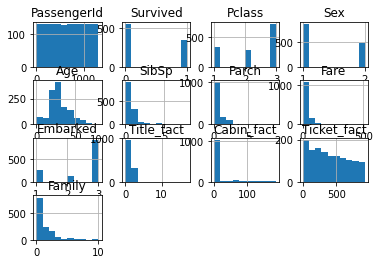

In [138]:
df2.hist()

In [299]:
# df2['Fare'].fillna(df2[(df_test['Pclass']==3) & (df2['Embarked']==3) & (df2['Sex']==1) & (df2['SibSp']==0) & (df2['Parch']==0) & (df2['Age'] > 40)].Fare.mean(), inplace=True)

# Filtering a similar dataset based on the missing value attributes
df2['Fare'].fillna(df2[(df2['Pclass']==3) & (df2['Embarked']==3) & (df2['Sex']==1) & (df2['Age'] > 40) & (df2['SibSp']==0) & (df2['Parch']==0)].Fare.median(), inplace=True)

In [140]:
df2.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title_fact,Cabin_fact,Ticket_fact,Family
count,1309.000000,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,0.383838,2.294882,1.355997,29.261398,0.498854,0.385027,33.276042,2.493506,0.910619,19.281131,405.414057,0.883881
std,378.020061,0.486592,0.837836,0.478997,13.218275,1.041658,0.865560,51.743658,0.814244,1.680647,42.871426,267.867110,1.583639
min,1.000000,0.000000,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,1.000000,22.000000,0.000000,0.000000,7.895800,2.000000,0.000000,0.000000,166.000000,0.000000
50%,655.000000,0.000000,3.000000,1.000000,26.000000,0.000000,0.000000,14.454200,3.000000,0.000000,0.000000,373.000000,0.000000
75%,982.000000,1.000000,3.000000,2.000000,36.000000,1.000000,0.000000,31.275000,3.000000,2.000000,0.000000,627.000000,1.000000
max,1309.000000,1.000000,3.000000,2.000000,80.000000,8.000000,9.000000,512.329200,3.000000,17.000000,186.000000,928.000000,10.000000


In [300]:
# Separating out the train and test dataset
df2_test = df2[df2.Survived.isnull()]
df2 = df2[~df2.Survived.isnull()]
df2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_fact,Cabin_fact,Ticket_fact,Family
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NA,3,Mr,0,0,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",2,38.0,1,0,PC 17599,71.2833,C85,1,Mrs,1,1,1,1
2,3,1.0,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NA,3,Miss,2,0,2,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,C123,3,Mrs,1,2,3,1
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NA,3,Mr,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0.0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,NA,3,Rev,5,0,677,0
887,888,1.0,1,"Graham, Miss. Margaret Edith",2,19.0,0,0,112053,30.0000,B42,3,Miss,2,146,678,0
888,889,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",2,22.0,1,2,W./C. 6607,23.4500,NA,3,Miss,2,0,614,3
889,890,1.0,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.0000,C148,1,Mr,0,147,679,0


In [187]:
# X_train, X_test, y_train, y_test = train_test_split(df2.drop(['Survived', 'Name', 'Ticket', 'Cabin', 'Title', 'PassengerId', 'Parch', 'Family'], axis=1), df2['Survived'], test_size=0.20, random_state=0) 86.59%
# X_train, X_test, y_train, y_test = train_test_split(df2.drop(['Survived', 'Name', 'Ticket', 'Cabin', 'Title', 'PassengerId'], axis=1), df2['Survived'], test_size=0.20, random_state=0) 86.03%

# Splitting the train dataset for validation
X_train, X_test, y_train, y_test = train_test_split(df2.drop(['Survived', 'Name', 'Ticket', 'Cabin', 'Title', 'PassengerId', 'Parch', 'Family', 'Ticket_fact'], axis=1), df2['Survived'], test_size=0.20, random_state=0)

In [188]:
X_train

,Pclass,Sex,Age,SibSp,Fare,Embarked,Title_fact,Cabin_fact
140,3,2,22.0,0,15.2458,1,1,0
439,2,1,31.0,0,10.5000,3,0,0
817,2,1,31.0,1,37.0042,1,0,0
378,3,1,20.0,0,4.0125,1,0,0
491,3,1,21.0,0,7.2500,3,0,0
...,...,...,...,...,...,...,...,...
835,1,2,39.0,1,83.1583,1,2,140
192,3,2,19.0,1,7.8542,3,2,0
629,3,1,25.0,0,7.7333,2,0,0
559,3,2,36.0,1,17.4000,3,1,0


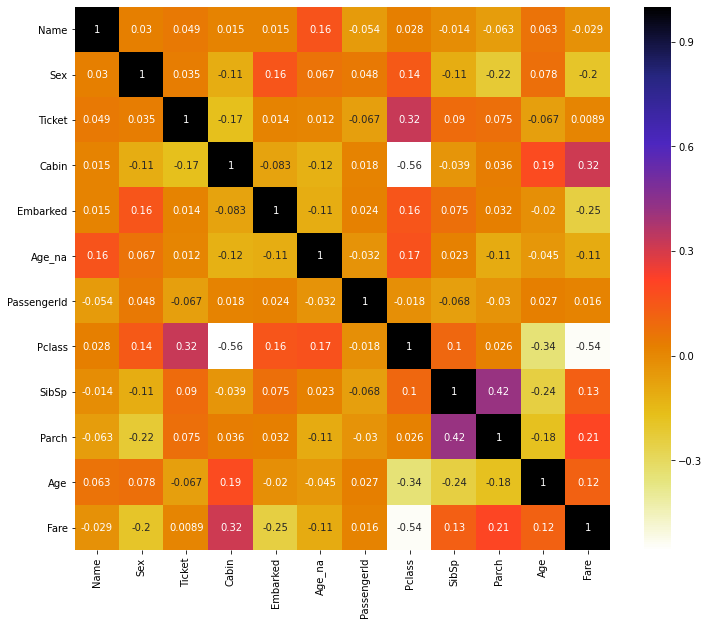

In [291]:
# Checking independent feature interdependability for feature selection
import seaborn as sns

plt.figure(figsize=(12,10))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

# XGBoost hyperparameter tuning

In [190]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [191]:
from sklearn.metrics import mean_absolute_error

In [192]:
# Just checking the baseline predictions at the initial stage

# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))

Baseline MAE is 0.47


In [193]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}

In [194]:
params['eval_metric'] = "mae"

In [195]:
num_boost_round = 999

In [196]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[19:43:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:0.41927
[1]	Test-mae:0.36134
[2]	Test-mae:0.31999
[3]	Test-mae:0.29567
[4]	Test-mae:0.27496
[5]	Test-mae:0.26233
[6]	Test-mae:0.24943
[7]	Test-mae:0.24330
[8]	Test-mae:0.23691
[9]	Test-mae:0.23549
[10]	Test-mae:0.23495
[11]	Test-mae:0.23302
[12]	Test-mae:0.23412
[13]	Test-mae:0.23208
[14]	Test-mae:0.23287
[15]	Test-mae:0.23231
[16]	Test-mae:0.23241
[17]	Test-mae:0.23110
[18]	Test-mae:0.23038
[19]	Test-mae:0.23098
[20]	Test-mae:0.22794
[21]	Test-mae:0.22643
[22]	Test-mae:0.22754
[23]	Test-mae:0.22811
[24]	Test-mae:0.22753
[25]	Test-mae:0.22919
[26]	Test-mae:0.22911
[27]	Test-mae:0.22978
[28]	Test-mae:0.23045
[29]	Test-mae:0.23201
[30]	Test-mae:0.23317


In [197]:
print("Best MAE: {:.3f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best MAE: 0.226 with 22 rounds


In [198]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

[19:43:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,0.406550,0.003060,0.426922,0.005165
1,0.337273,0.004234,0.373146,0.009202
2,0.286005,0.002321,0.338935,0.011574
3,0.247952,0.003053,0.313043,0.013000
4,0.219483,0.003591,0.293845,0.012621
5,0.198236,0.005234,0.281430,0.012832
6,0.180258,0.003956,0.274692,0.012693
7,0.168118,0.004822,0.269719,0.013590
8,0.158981,0.004682,0.265445,0.014011
9,0.150313,0.005732,0.262820,0.013627


In [199]:
cv_results['test-mae-mean'].min()

0.25636580000000003

In [200]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [201]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=9, min_child_weight=5
[19:44:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.25580980000000003 for 11 rounds
CV with max_depth=9, min_child_weigh

In [202]:
params['max_depth'] = 11
params['min_child_weight'] = 5

In [203]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [204]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
[19:44:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.2556606 for 13 rounds
CV with subsample=1.0, colsample=0.9
[19:44:12] W

	MAE 0.2615054 for 10 rounds
CV with subsample=0.8, colsample=0.8
[19:44:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.26817579999999996 for 9 rounds
CV with sub

In [205]:
params['subsample'] = 1.
params['colsample_bytree'] = 1.

In [206]:
%time
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics=['mae'], early_stopping_rounds=10)
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

Wall time: 0 ns
CV with eta=0.3
[19:44:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:44:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 116 ms
	MAE 0.2556606 for 13 rounds

CV with eta=0.2
[19:44:24] WARNING:

In [207]:
params['eta'] = 0.3

In [208]:
params

{'max_depth': 11,
 'min_child_weight': 5,
 'eta': 0.3,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'reg:linear',
 'eval_metric': 'mae'}

In [209]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.5f} in {} rounds".format(model.best_score, model.best_iteration+1))

[19:44:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:0.42138
[1]	Test-mae:0.36509
[2]	Test-mae:0.32504
[3]	Test-mae:0.29786
[4]	Test-mae:0.27643
[5]	Test-mae:0.25930
[6]	Test-mae:0.24627
[7]	Test-mae:0.23799
[8]	Test-mae:0.23535
[9]	Test-mae:0.23151
[10]	Test-mae:0.22751
[11]	Test-mae:0.22704
[12]	Test-mae:0.22709
[13]	Test-mae:0.22900
[14]	Test-mae:0.22840
[15]	Test-mae:0.22466
[16]	Test-mae:0.22387
[17]	Test-mae:0.22373
[18]	Test-mae:0.22387
[19]	Test-mae:0.22384
[20]	Test-mae:0.22367
[21]	Test-mae:0.22361
[22]	Test-mae:0.22369
[23]	Test-mae:0.22411
[24]	Test-mae:0.22359
[25]	Test-mae:0.22419
[26]	Test-mae:0.22504
[27]	Test-mae:0.22564
[28]	Test-mae:0.22623
[29]	Test-mae:0.22759
[30]	Test-mae:0.22884
[31]	Test-mae:0.22800
[32]	Test-mae:0.22955
[33]	Test-mae:0.22960
[34]	Test-mae:0.23007
Best MAE: 0.22359 in 25 rounds


From 0.47 to 0.22621

In [210]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[19:44:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:0.42138
[1]	Test-mae:0.36509
[2]	Test-mae:0.32504
[3]	Test-mae:0.29786
[4]	Test-mae:0.27643
[5]	Test-mae:0.25930
[6]	Test-mae:0.24627
[7]	Test-mae:0.23799
[8]	Test-mae:0.23535
[9]	Test-mae:0.23151
[10]	Test-mae:0.22751
[11]	Test-mae:0.22704
[12]	Test-mae:0.22709
[13]	Test-mae:0.22900
[14]	Test-mae:0.22840
[15]	Test-mae:0.22466
[16]	Test-mae:0.22387
[17]	Test-mae:0.22373
[18]	Test-mae:0.22387
[19]	Test-mae:0.22384
[20]	Test-mae:0.22367
[21]	Test-mae:0.22361
[22]	Test-mae:0.22369
[23]	Test-mae:0.22411
[24]	Test-mae:0.22359


In [211]:
mean_absolute_error(best_model.predict(dtest), y_test)

0.2235947988833712

In [212]:
(np.max(best_model.predict(dtest)) + np.min(best_model.predict(dtest)) ) / 2

0.4986598491668701

In [213]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
y_pred = np.where(best_model.predict(dtest) > 0.4986598491668701, 1, 0) 

print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[103   7]
 [ 18  51]]
0.8603351955307262
              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89       110
         1.0       0.88      0.74      0.80        69

    accuracy                           0.86       179
   macro avg       0.87      0.84      0.85       179
weighted avg       0.86      0.86      0.86       179



# Random Forest Hyperparameter

In [214]:
import warnings
warnings.filterwarnings('ignore')

In [215]:
X_test

,Pclass,Sex,Age,SibSp,Fare,Embarked,Title_fact,Cabin_fact
495,3,1,25.0,0,14.4583,1,0,0
648,3,1,25.0,0,7.5500,3,0,0
278,3,1,7.0,4,29.1250,2,3,0
31,1,2,36.0,1,146.5208,1,1,9
255,3,2,29.0,0,15.2458,1,1,0
...,...,...,...,...,...,...,...,...
780,3,2,13.0,0,7.2292,1,2,0
837,3,1,25.0,0,8.0500,3,0,0
215,1,2,31.0,1,113.2750,1,2,38
833,3,1,23.0,0,7.8542,3,0,0


In [248]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(X_train, y_train)
prediction = rf_classifier.predict(X_test)

In [249]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(confusion_matrix(y_test, prediction))
print(accuracy_score(y_test, prediction))
print(classification_report(y_test, prediction))

[[102   8]
 [ 18  51]]
0.8547486033519553
              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89       110
         1.0       0.86      0.74      0.80        69

    accuracy                           0.85       179
   macro avg       0.86      0.83      0.84       179
weighted avg       0.86      0.85      0.85       179



#### Randomly selecting the parameters; not feasible with hyperparameter tuning

In [218]:
# Manual Hyperparameter Tuning

model=RandomForestClassifier(n_estimators=300, criterion='entropy', 
                            max_features='sqrt', min_samples_leaf=10, random_state=100).fit(X_train, y_train)
prediction = model.predict(X_test)

print(confusion_matrix(y_test, prediction))
print(accuracy_score(y_test, prediction))
print(classification_report(y_test, prediction))

[[95 15]
 [22 47]]
0.7932960893854749
              precision    recall  f1-score   support

         0.0       0.81      0.86      0.84       110
         1.0       0.76      0.68      0.72        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179



 ##### Randomized Search CV

In [219]:
from sklearn.model_selection import RandomizedSearchCV

In [220]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num=100)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000, 10)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 14]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': ['entropy', 'gini']
    
    
}
print(random_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [221]:
rf=RandomForestClassifier()
rf_randomcv=RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=100, n_jobs=-1)

rf_randomcv.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
   

In [222]:
best_random_grid = rf_randomcv.best_estimator_

In [223]:
rf_randomcv.best_params_

{'n_estimators': 420,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 120,
 'criterion': 'gini'}

In [224]:
y_pred = best_random_grid.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[101   9]
 [ 21  48]]
0.8324022346368715
              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87       110
         1.0       0.84      0.70      0.76        69

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



# GridSearchCV

In [225]:
from sklearn.model_selection import GridSearchCV

In [226]:
param_grid = {
    'criterion': [rf_randomcv.best_params_['criterion']],
    'max_depth': [rf_randomcv.best_params_['max_depth']],
    'max_features': [rf_randomcv.best_params_['max_features']],
    'min_samples_leaf': [rf_randomcv.best_params_['min_samples_leaf'],
                        rf_randomcv.best_params_['min_samples_leaf']+2,
                        rf_randomcv.best_params_['min_samples_leaf']+4],
    'min_samples_split': [rf_randomcv.best_params_['min_samples_split'] -2,
                         rf_randomcv.best_params_['min_samples_split'] -1,
                         rf_randomcv.best_params_['min_samples_split'],
                         rf_randomcv.best_params_['min_samples_split'] + 1,
                         rf_randomcv.best_params_['min_samples_split'] + 2],
    'n_estimators': [rf_randomcv.best_params_['n_estimators'] - 311,
                    rf_randomcv.best_params_['n_estimators'] - 200,
                    rf_randomcv.best_params_['n_estimators'] - 100, 
                    rf_randomcv.best_params_['n_estimators'] + 100,
                    rf_randomcv.best_params_['n_estimators'] + 200]
                        
    
    
}

print(param_grid)

{'criterion': ['gini'], 'max_depth': [120], 'max_features': ['log2'], 'min_samples_leaf': [4, 6, 8], 'min_samples_split': [0, 1, 2, 3, 4], 'n_estimators': [109, 220, 320, 520, 620]}


In [227]:
rf=RandomForestClassifier()
grid_search=GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 75 candidates, totalling 750 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [120],
                         'max_features': ['log2'],
                         'min_samples_leaf': [4, 6, 8],
                         'min_samples_split': [0, 1, 2, 3, 4],
                         'n_estimators': [109, 220, 320, 520, 620]},
             verbose=2)

In [228]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 120,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 620}

In [229]:
best_grid = grid_search.best_estimator_

In [230]:
best_grid

RandomForestClassifier(max_depth=120, max_features='log2', min_samples_leaf=4,
                       n_estimators=620)

In [231]:
y_pred = best_grid.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[102   8]
 [ 21  48]]
0.8379888268156425
              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88       110
         1.0       0.86      0.70      0.77        69

    accuracy                           0.84       179
   macro avg       0.84      0.81      0.82       179
weighted avg       0.84      0.84      0.83       179



# Test

In [236]:
df2_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     0 non-null      float64
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    int64  
 5   Age          418 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         418 non-null    float64
 10  Cabin        418 non-null    object 
 11  Embarked     418 non-null    int64  
 12  Title        418 non-null    object 
 13  Title_fact   418 non-null    int64  
 14  Cabin_fact   418 non-null    int64  
 15  Ticket_fact  418 non-null    int64  
 16  Family       418 non-null    int64  
dtypes: float64(3), int64(10), object(4)
memory usage: 58.8+ KB


In [238]:
# Test hyperparameter XGBoost
# Pclass	Sex	Age	Fare	Embarked	Title_fact	Cabin_fact	Ticket_fact	Family
# Pclass	Sex	Age	SibSp	Parch	Embarked	Title_fact	Cabin_fact	Family	Fare_log
# Pclass	Sex	Age	SibSp	Parch	Fare	Embarked	Title_fact	Cabin_fact	Ticket_fact	Family
# Pclass	Sex	Age	SibSp	Fare	Embarked	Title_fact	Cabin_fact

# Pclass	Sex	Age	SibSp	Fare	Embarked	Title_fact	Cabin_fact	Ticket_fact
# Pclass	Sex	Age	SibSp	Fare	Embarked	Title_fact	Cabin_fact


dtest_test = xgb.DMatrix(df2_test[['Pclass','Sex','Age', 'SibSp', 'Fare', 'Embarked', 'Title_fact', 'Cabin_fact']])

# (np.max(best_model.predict(dtest)) + np.min(best_model.predict(dtest)) ) / 2
(np.min(best_model.predict(dtest_test)) + np.max(best_model.predict(dtest_test))) / 2

0.5040535926818848

In [240]:
pred_test = np.where(best_model.predict(dtest_test) > 0.5040535926818848, 1, 0)

In [135]:
pred_test = rf_classifier.predict(df_test[['Pclass','Sex','Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title_fact', 'Cabin_fact', 'Ticket_fact', 'Family']])

In [243]:
# Predictions using the random forest grid search cv
pred_test = best_grid.predict(df2_test[['Pclass','Sex','Age', 'SibSp', 'Fare', 'Embarked', 'Title_fact', 'Cabin_fact']])

In [246]:
# Creating a new dataframe to hold the final form
df2_test['Survived'] = pred_test

final = df2_test[['PassengerId','Survived']]
final['Survived'] = final.Survived.astype(int)
final

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [247]:
# Writing the dataframe to a csv
final.to_csv('gender_submission.csv', index=False)